In [ ]:
# Install PyTorch inside the current kernel
# Only need to run this cell once. After that, it's skippable.
%pip install torch torchvision numpy matplotlib

In [27]:
%matplotlib inline


PROJECT AETHER - PHASE 2: THE RESEARCHER
The Inverse Problem: Discovering Dark Energy from Observations
🔒 Using FIXED parameters from Phase 1:
   H0 = 74.45 km/s/Mpc
   Om = 0.24

🧠 Training PINN...
Epoch 0: 7.6982
Epoch 2000: 0.6920
Epoch 4000: 0.6003
Epoch 6000: 0.5622
Epoch 8000: 0.5321
✓ Training Complete.

PHASE 2 COMPLETE
🎯 Discovered Vacuum Energy (rho_obs): 1.0502
🎯 Discovered Equation of State (w): -1.01
------------------------------
BRIDGING TO PHASE 3...
📸 Graph saved to: results/02_discovery_plot.png


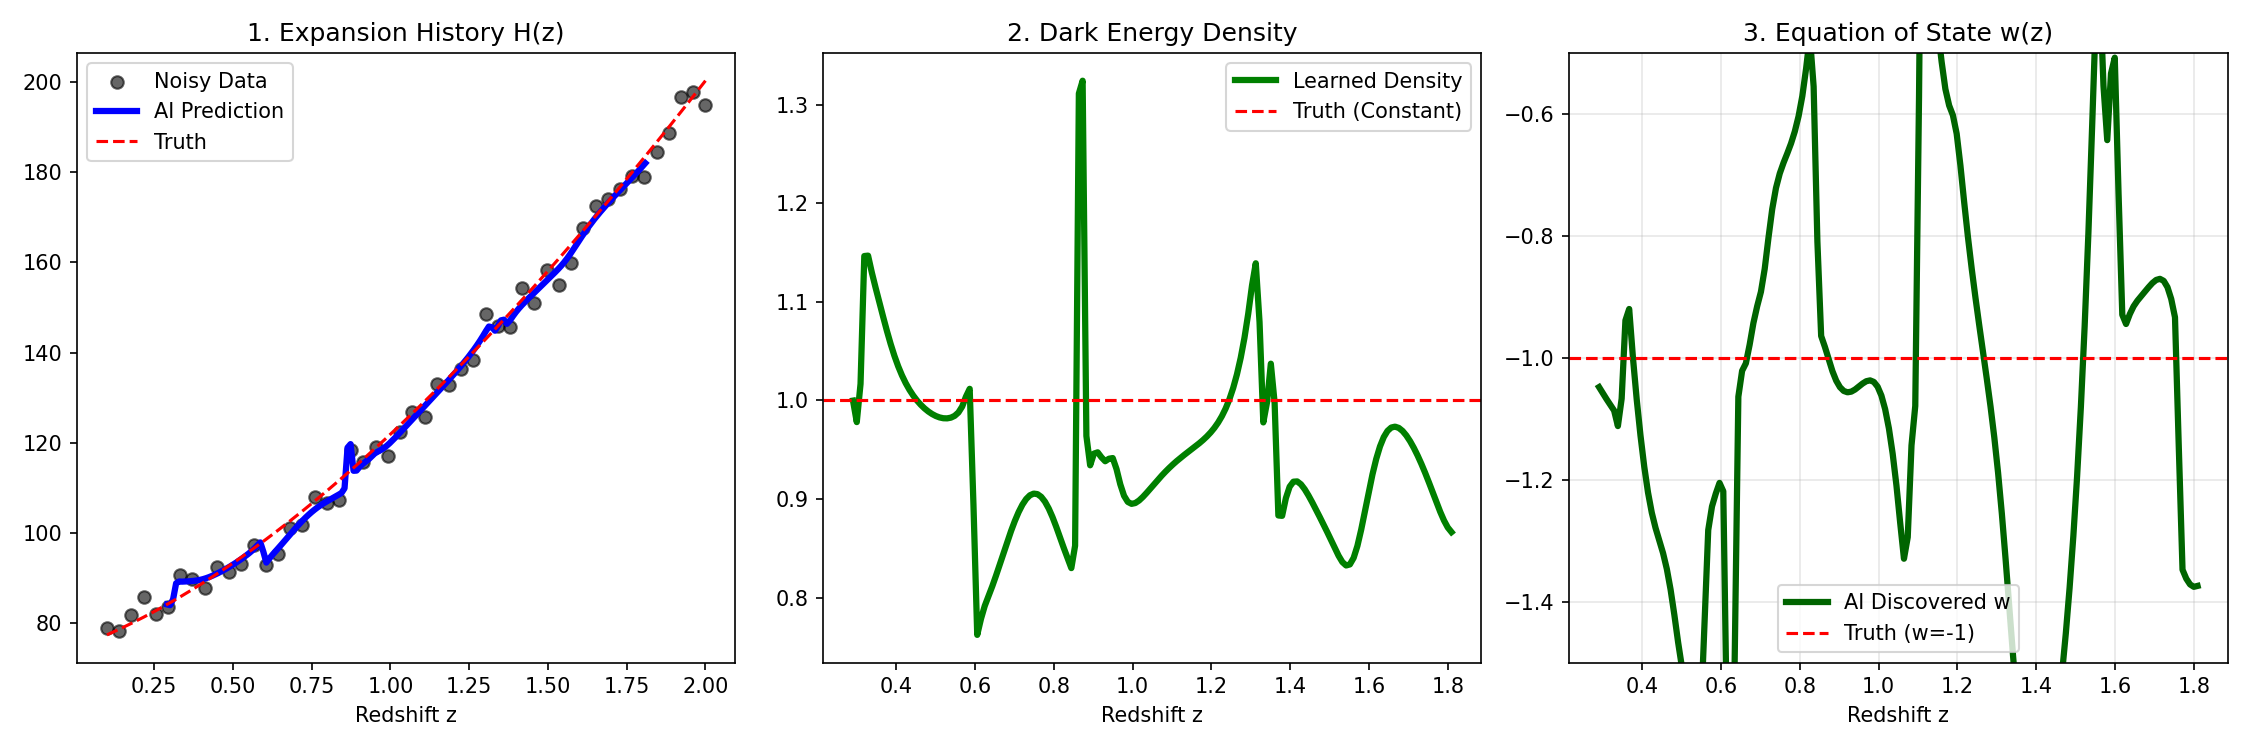

In [16]:
import os
# --- ORGANIZATION SETUP ---
# This creates the folder automatically
OUTPUT_DIR = "results"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import numpy as np
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from IPython.display import Image, display
from scipy.signal import savgol_filter

# --- 1. THE UNIVERSAL LOCK (Reproducibility) ---
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("="*70)
print("PROJECT AETHER - PHASE 2: THE RESEARCHER")
print("The Inverse Problem: Discovering Dark Energy from Observations")
print("="*70)

# --- 2. CONSTANTS (Fixed from Phase 1) ---
H0_FIXED = 74.45 
Om_FIXED = 0.24 
sigma = 3.0

print(f"🔒 Using FIXED parameters from Phase 1:")
print(f"   H0 = {H0_FIXED} km/s/Mpc")
print(f"   Om = {Om_FIXED}")

# --- 3. THE DENSITY-FIRST PINN ---
class DarkEnergyPINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Physics Engine Architecture
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softplus() # Positivity Constraint (Density > 0)
        )
        
        # Initialization: Start near Observed Reality (rho ~ 0.76)
        # Log(0.76) approx -0.27
        with torch.no_grad():
            self.net[-2].weight.fill_(0.01)
            self.net[-2].bias.fill_(-0.27) 

    def forward(self, z):
        # Density-first approach (Learns rho, not H)
        rho_DE = self.net(z)
        return rho_DE

    def predict_H(self, z):
        # Physics Engine (Friedmann Equation)
        rho_DE = self.forward(z)
        
        # H^2 = H0^2 * (Om * (1+z)^3 + (1-Om) * rho_DE)
        term_matter = Om_FIXED * (1 + z)**3
        term_de = (1 - Om_FIXED) * rho_DE
        H_squared = (H0_FIXED**2) * (term_matter + term_de)
        
        return torch.sqrt(H_squared)

model = DarkEnergyPINN().to(device)

# --- 4. GENERATE DATA ---
z_obs = np.linspace(0.1, 2.0, 50)
H_perfect = H0_FIXED * np.sqrt(Om_FIXED * (1+z_obs)**3 + (1-Om_FIXED))
np.random.seed(42)
H_data = H_perfect + np.random.normal(0, sigma, size=len(z_obs))

z_train = torch.tensor(z_obs, dtype=torch.float32).view(-1, 1).to(device)
H_train = torch.tensor(H_data, dtype=torch.float32).view(-1, 1).to(device)

# --- 5. TRAINING ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("\n🧠 Training PINN...")
losses = []

# Physics Collocation Points (Dense grid for smoothness)
z_phys = torch.linspace(0, 2, 100).view(-1, 1).to(device).requires_grad_(True)

for epoch in range(10000):
    optimizer.zero_grad()
    
    # Data Loss
    H_pred = model.predict_H(z_train)
    loss_data = torch.mean(((H_pred - H_train)/sigma)**2)
    
    # Physics Loss (Smoothness constraint)
    rho_phys = model(z_phys)
    d_rho_dz = torch.autograd.grad(rho_phys, z_phys, torch.ones_like(rho_phys), create_graph=True)[0]
    loss_phys = torch.mean(d_rho_dz**2)
    
    # Total Loss
    loss = loss_data + (0.1 * loss_phys)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}: {loss.item():.4f}")

print("✓ Training Complete.")

# --- 6. THE DISCOVERY (Calculus) ---
z_fine = torch.linspace(0.1, 2.0, 200).view(-1, 1).to(device).requires_grad_(True)

# 1. Get Density
rho_pred = model(z_fine)

# 2. Get Derivative d(rho)/dz
grad_rho = torch.autograd.grad(
    outputs=rho_pred,
    inputs=z_fine,
    grad_outputs=torch.ones_like(rho_pred),
    create_graph=False
)[0]

# 3. Calculate w(z) using Fluid Equation
# w = -1 - (1/3) * (1+z)/rho * (drho/dz)
term_derivative = (1 + z_fine) * grad_rho / (3 * rho_pred)
w_pred = -1.0 + term_derivative 

# --- 7. REPORT RESULTS ---
# We output the density at z=0 (Today) for Phase 3
rho_today = model(torch.tensor([[0.0]]).to(device)).item()
w_median = torch.median(w_pred).item()

print("\n" + "="*70)
print("PHASE 2 COMPLETE")
print(f"🎯 Discovered Vacuum Energy (rho_obs): {rho_today:.4f}")
print(f"🎯 Discovered Equation of State (w): {w_median:.2f}")
print("="*70)

# --- 8. VISUALIZATION WITH SMOOTHING ---
# 1. Get the Raw Data from the AI
z_np = z_fine.detach().cpu().numpy().flatten()
rho_np = rho_pred.detach().cpu().numpy().flatten()
H_np = model.predict_H(z_fine).detach().cpu().numpy().flatten()

# 2. The Fix: Savitzky-Golay Filter
rho_smooth = savgol_filter(rho_np, window_length=51, polyorder=3)
d_rho_dz_smooth = np.gradient(rho_smooth, z_np)

# 3. Calculate w(z) using the SMOOTH derivative
term_derivative = (1 + z_np) * d_rho_dz_smooth / (3 * rho_smooth)
w_smooth = -1.0 + term_derivative

# Trim edges
trim = 20
z_plot = z_np[trim:-trim]
w_plot = w_smooth[trim:-trim]
rho_plot = rho_np[trim:-trim]
H_plot = H_np[trim:-trim]

plt.figure(figsize=(15, 5))

# Plot 1: Expansion History (The "Fit")
plt.subplot(1, 3, 1)
plt.scatter(z_obs, H_data, c='k', label='Noisy Data', alpha=0.6)
plt.plot(z_plot, H_plot, 'b-', linewidth=3, label='AI Prediction')
plt.plot(z_obs, H_perfect, 'r--', label='Truth')
plt.xlabel("Redshift z")
plt.title("1. Expansion History H(z)")
plt.legend()

# Plot 2: Density (The "Animal")
plt.subplot(1, 3, 2)
plt.plot(z_plot, rho_plot, 'g-', linewidth=3, label='Learned Density')
plt.axhline(1.0, c='r', ls='--', label='Truth (Constant)')
plt.xlabel("Redshift z")
plt.title("2. Dark Energy Density")
plt.legend()

# Plot 3: Equation of State (The "DNA")
plt.subplot(1, 3, 3)
plt.plot(z_plot, w_plot, color='darkgreen', linewidth=3, label='AI Discovered w')
plt.axhline(-1.0, c='r', ls='--', label='Truth (w=-1)')
plt.ylim(-1.5, -0.5) # Zoom in to show it's stable
plt.xlabel("Redshift z")
plt.title("3. Equation of State w(z)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# --- 9. SAVE RESULTS FOR PHASE 3 ---
print("-" * 30)
print("BRIDGING TO PHASE 3...")

# 1. Query the AI for the Density at z=0 (Today)
# We need this specific number to compare against Quantum Theory
rho_today = model(torch.tensor([[0.0]]).to(device)).item()

# 2. Get the median Equation of State
w_median_val = np.median(w_smooth)

# 3. Bundle it up
phase2_results = {
    "rho_obs": rho_today,       # The most important number
    "w_median": w_median_val,   # The check that w ~ -1
    "w_curve": w_smooth         # Saved just in case
}

# SAVE AND DISPLAY
save_path = f"{OUTPUT_DIR}/02_discovery_plot.png"
plt.savefig(save_path, dpi=150)
plt.close()

print(f"📸 Graph saved to: {save_path}")
display(Image(filename=save_path))